In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [57]:
# データの読み込み
train_df = pd.read_csv('~/github/my_signage/data/raw/train.csv')
test_df = pd.read_csv('~/github/my_signage/data/raw/test.csv')

# 欠損値 -1 を　 NaNに置き換える
train_df[['price_am', 'price_pm']] = train_df[['price_am', 'price_pm']].replace(-1, np.nan)
test_df[['price_am', 'price_pm']] = test_df[['price_am', 'price_pm']].replace(-1, np.nan)

train_df['is_train'] = 1
test_df['is_train'] = 0

train_cols = train_df.columns.tolist() # 列名（カラム名）をリスト形式で取得
test_cols = test_df.columns.tolist()
common_cols = list(set(train_cols) & set(test_cols)) # 共通のカラム
train_only = list(set(train_cols) - set(common_cols))  # 訓練データのみのカラム
test_only = list(set(test_cols) - set(common_cols))    # テストデータのみのカラム

for col in train_only:
    test_df[col] = None

for col in test_only:
    train_df[col] = None

merged_df = pd.concat([train_df, test_df], ignore_index=True, sort=False)

pd.set_option('future.no_silent_downcasting', True)
merged_df['y'] = merged_df['y'].fillna(0).astype(int)


merged_df['datetime'] = pd.to_datetime(merged_df['datetime'])
merged_df['year'] = merged_df['datetime'].apply(lambda x: x.year)
merged_df['month'] = merged_df['datetime'].apply(lambda x: x.month)
merged_df['weekday'] = merged_df['datetime'].apply(lambda x: x.weekday())

merged_df 

,datetime,y,client,close,price_am,price_pm,is_train,year,month,weekday
0,2010-07-01,17,0,0,NaN,NaN,1,2010,7,3
1,2010-07-02,18,0,0,NaN,NaN,1,2010,7,4
2,2010-07-03,20,0,0,NaN,NaN,1,2010,7,5
3,2010-07-04,20,0,0,NaN,NaN,1,2010,7,6
4,2010-07-05,14,0,0,NaN,NaN,1,2010,7,0
...,...,...,...,...,...,...,...,...,...,...
2461,2017-03-27,0,0,0,5.0,4.0,0,2017,3,0
2462,2017-03-28,0,0,0,4.0,4.0,0,2017,3,1
2463,2017-03-29,0,0,0,3.0,3.0,0,2017,3,2
2464,2017-03-30,0,0,0,4.0,3.0,0,2017,3,3


In [58]:
### EDA ###

# 欠損値の確認
l = '============================================'
print('欠損値:')
print('訓練データ')
print(train_df.isnull().sum())
print('テストデータ')
print(test_df.isnull().sum())
print(l)
print('データ型')
print(merged_df.dtypes)
print(l)
print(train_df.describe())

欠損値:
訓練データ
datetime      0
y             0
client        0
close         0
price_am    211
price_pm    212
is_train      0
dtype: int64
テストデータ
datetime      0
client        0
close         0
price_am      5
price_pm      5
is_train      0
y           365
dtype: int64
データ型
datetime    datetime64[ns]
y                    int64
client               int64
close                int64
price_am           float64
price_pm           float64
is_train             int64
year                 int64
month                int64
weekday              int64
dtype: object
                 y       client        close     price_am     price_pm  \
count  2101.000000  2101.000000  2101.000000  1890.000000  1889.000000   
mean     34.096621     0.098049     0.012851     0.794709     0.546850   
std      17.476234     0.297451     0.112658     1.044370     0.903766   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      21.000000     0.000000     0.000000     0.000000     0.000000   

<Axes: >

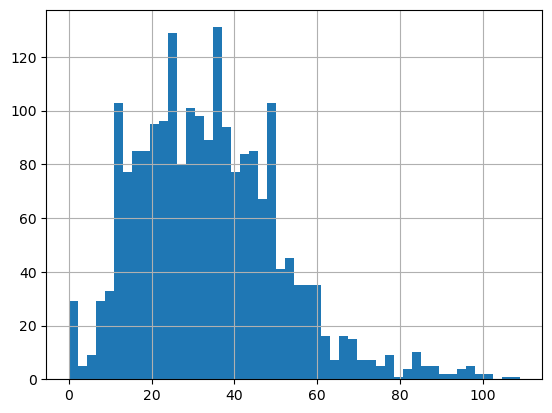

In [59]:
train_df['y'].hist(bins=50)

In [60]:
merged_df1 = merged_df.set_index('datetime', inplace=False)
merged_df1

,y,client,close,price_am,price_pm,is_train,year,month,weekday
datetime,,,,,,,,,
2010-07-01,17,0,0,NaN,NaN,1,2010,7,3
2010-07-02,18,0,0,NaN,NaN,1,2010,7,4
2010-07-03,20,0,0,NaN,NaN,1,2010,7,5
2010-07-04,20,0,0,NaN,NaN,1,2010,7,6
2010-07-05,14,0,0,NaN,NaN,1,2010,7,0
...,...,...,...,...,...,...,...,...,...
2017-03-27,0,0,0,5.0,4.0,0,2017,3,0
2017-03-28,0,0,0,4.0,4.0,0,2017,3,1
2017-03-29,0,0,0,3.0,3.0,0,2017,3,2


In [61]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    # データフレーム作成
    adf_df = pd.DataFrame(
        [
            adfuller(series)[1]
        ],
        columns=['P値']
    )
    # 有効数字3桁にする
    adf_df['P値'] = adf_df['P値'].round(decimals=3).astype(str)
    print(adf_df)

adf_test(series=train_df['y'])

      P値
0  0.575


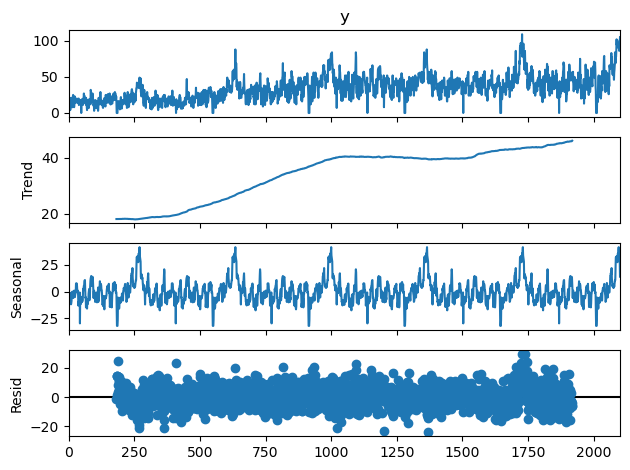

In [67]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 訓練データに対して季節性、トレンドの確認
price_am_seasonal = seasonal_decompose(merged_df[merged_df['is_train']==1].y, model='additive', period=365)

# 分解結果のプロット
fig = price_am_seasonal.plot()
plt.show()

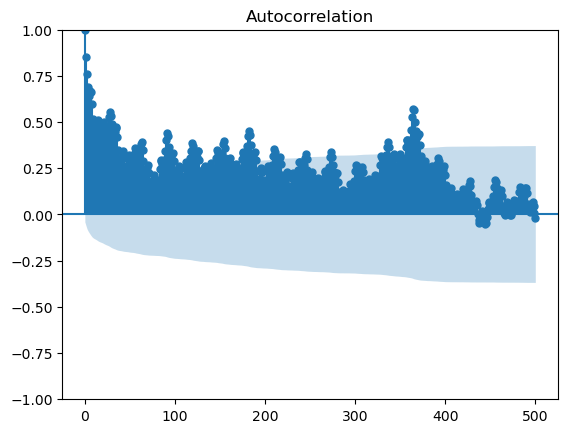

In [69]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(train_df['y'], lags=500)
plt.show()

In [70]:
# ラグ特徴量の追加

merged_df['y_lag_7'] = merged_df['y'].shift(7)
merged_df['y_lag_365'] = merged_df['y'].shift(365)

for lag in [1, 7, 365]:
    merged_df[f'price_am_lag_{lag}'] = merged_df['price_am'].shift(lag)

for lag in [1, 7, 365]:
    merged_df[f'price_pm_lag_{lag}'] = merged_df['price_pm'].shift(lag)


# 移動平均の追加
windows = [7, 30]
for window in windows:
    merged_df[f'price_am_moving_avg_{window}'] = merged_df['price_am'].rolling(window=window).mean()

for window in windows:
    merged_df[f'price_pm_moving_avg_{window}'] = merged_df['price_pm'].rolling(window=window).mean()

In [71]:
merged_df

,datetime,y,client,close,price_am,price_pm,is_train,year,month,weekday,...,price_am_lag_1,price_am_lag_7,price_am_lag_365,price_pm_lag_1,price_pm_lag_7,price_pm_lag_365,price_am_moving_avg_7,price_am_moving_avg_30,price_pm_moving_avg_7,price_pm_moving_avg_30
0,2010-07-01,17,0,0,NaN,NaN,1,2010,7,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-07-02,18,0,0,NaN,NaN,1,2010,7,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-07-03,20,0,0,NaN,NaN,1,2010,7,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-07-04,20,0,0,NaN,NaN,1,2010,7,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-07-05,14,0,0,NaN,NaN,1,2010,7,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2461,2017-03-27,0,0,0,5.0,4.0,0,2017,3,0,...,4.0,3.0,5.0,4.0,4.0,4.0,3.857143,2.166667,4.000000,2.166667
2462,2017-03-28,0,0,0,4.0,4.0,0,2017,3,1,...,5.0,4.0,4.0,4.0,4.0,4.0,3.857143,2.233333,4.000000,2.233333
2463,2017-03-29,0,0,0,3.0,3.0,0,2017,3,2,...,4.0,2.0,4.0,4.0,4.0,4.0,4.000000,2.266667,3.857143,2.266667
2464,2017-03-30,0,0,0,4.0,3.0,0,2017,3,3,...,3.0,3.0,5.0,3.0,2.0,4.0,4.142857,2.333333,4.000000,2.300000
